In [56]:
%matplotlib inline

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPClassifier

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

plt.rcParams['figure.figsize'] = (12, 12)

The FMA Dataset provides a utility package for parsing the data into Pandas datasets:

In [57]:
import fma.utils as utils

In [58]:
# Directory where mp3 are stored.
#AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
full_tracks = utils.load('fma/data/fma_metadata/tracks.csv')
genres = utils.load('fma/data/fma_metadata/genres.csv')
full_features = utils.load('fma/data/fma_metadata/features.csv')
full_echonest = utils.load('fma/data/fma_metadata/echonest.csv')


### Exploration of Dataset:

In [59]:
print(f"Number of Samples: {full_tracks.shape[0]}")
print(f"Number of Raw Features: {full_features.shape[1]}")
print(f"Number of Catagorical Variables: {0}")
print(f"Fraction of Missing Values: {0}")
print(full_tracks.keys())

Number of Samples: 106574
Number of Raw Features: 518
Number of Catagorical Variables: 0
Fraction of Missing Values: 0
MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',    

### Feature Engineering

First, I seperate the full 100,000 track dataset into a much smaller subset, with only 8000 tracks. This will make training feasible with my limited computational power. I also extract the top genres from each track, which serve as the classification label for each track.

In [60]:
features = full_features[full_tracks['set', 'subset'] <= 'small']
tracks = full_tracks[full_tracks['set', 'subset'] <= 'small']
genres = tracks['track', 'genre_top']

print(f"Adjusted number of samples: {features.shape[0]}")
print(genres.shape)

Adjusted number of samples: 8000
(8000,)


(x-mean)/std_dev, important as the different features will have different units and thus different scales. This puts them all on the same scale, and is valid assuming they're generated from a gaussain distribution.

In [61]:
features = sklearn.preprocessing.StandardScaler().fit_transform(features)
print(f"Mean of the first feature after standardization: {np.mean(features[:, 0])}")
print(f"Standard Deviation of the first feature after standarization: {np.std(features[:, 0])}")

Mean of the first feature after standardization: -1.0658141036401503e-17
Standard Deviation of the first feature after standarization: 1.0


/home/jack/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/jack/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [62]:
pca = sklearn.decomposition.PCA(n_components=100)
pca_features = pca.fit_transform(np.asarray(features))
print(sum(pca.explained_variance_ratio_))

0.8344984789434238


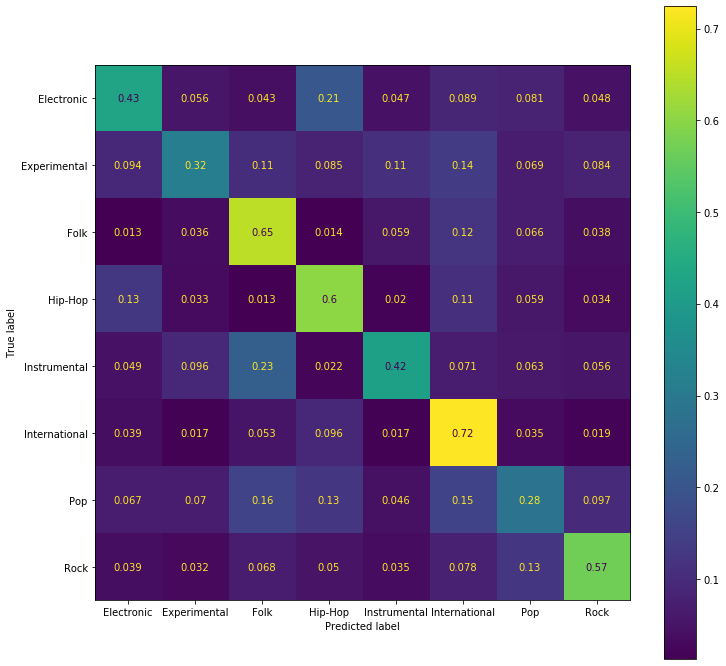

In [63]:
kfold = sklearn.model_selection.KFold(n_splits=10, random_state=0, shuffle=True)
kneighbors = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
conf_matrixes = []
for train_i, test_i in kfold.split(pca_features):
    train_i = np.asarray(train_i)
    test_i = np.asarray(test_i)
    kneighbors.fit(pca_features[train_i], np.asarray(genres)[train_i])
    genres_pred = kneighbors.predict(pca_features[test_i])
    conf_matrix = sklearn.metrics.confusion_matrix(np.asarray(genres)[test_i], genres_pred, normalize='true')   
    conf_matrixes.append(conf_matrix)

final_conf_matrix = sum(conf_matrixes)/10
disp = sklearn.metrics.ConfusionMatrixDisplay(final_conf_matrix, display_labels=kneighbors.classes_) 
disp.plot()
plt.show()


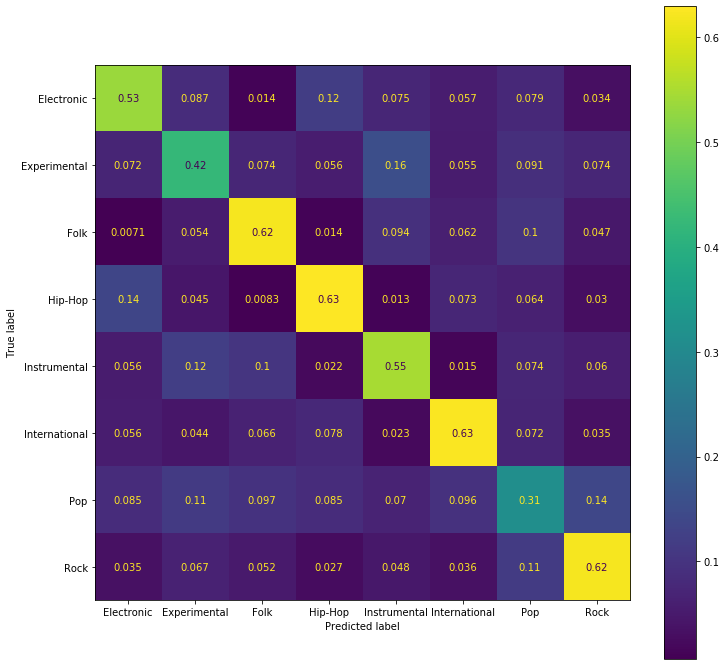

In [64]:
kfold = sklearn.model_selection.KFold(n_splits=10, random_state=0, shuffle=True)
nn = MLPClassifier([100, 60, 20], solver='sgd', activation='relu')
conf_matrixes = []
for train_i, test_i in kfold.split(pca_features):
    train_i = np.asarray(train_i)
    test_i = np.asarray(test_i)
    nn.fit(pca_features[train_i], np.asarray(genres)[train_i])
    genres_pred = nn.predict(pca_features[test_i])
    conf_matrix = sklearn.metrics.confusion_matrix(np.asarray(genres)[test_i], genres_pred, normalize='true')   
    conf_matrixes.append(conf_matrix)

final_conf_matrix = sum(conf_matrixes)/10
disp = sklearn.metrics.ConfusionMatrixDisplay(final_conf_matrix, display_labels=kneighbors.classes_) 
disp.plot()
plt.show()
